In [1]:
import dolfin as dl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import scipy.integrate as si
import scipy.optimize as so

import torch
import torch.nn as nn
import torch.nn.functional as F

# Create the Network

In [39]:
class NN(nn.Module):
    def __init__(self):
        super(NN,self).__init__()
        self.fc1 = nn.Linear(1, 3)
        self.fc2 = nn.Linear(3, 1)
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.uniform_()
            if module.bias is not None:
                module.bias.data.zero_()

        
    def forward(self, x):
        x = torch.tensor([x])
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x.item()
    
    def vector_eval(self, x, m):
        i = 0
        for xi in x:
            m[i] = self.forward(xi)
            i += 1

# Testing model

# Set device

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Creating component needed for model

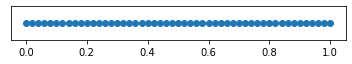

In [205]:
# number of elements for training and testing data
n_train = 50
n_test  = 101

# Create mesh for training and testing data
mesh_train = dl.UnitIntervalMesh(n_train)
mesh_test = dl.UnitIntervalMesh(n_test)

# Create vector version of mesh
mesh_vec = np.linspace(0,1,n_train)

# Define the function space
Vh = dl.FunctionSpace(mesh_train, 'Lagrange', 1)

# Show the mesh
dl.plot(mesh_train)
plt.show()


In [217]:
def ud_boundary(x, on_boundary):
    return on_boundary

# Define boundary conditions
ud = dl.Constant('0.0')
bc = dl.DirichletBC(Vh, ud, ud_boundary)



In [224]:
class FEM_function:
    def __init__(self, Vh, vec_mesh, bc):
        self.Vh = Vh
        self.vec_mesh = vec_mesh
        self.bc = bc
        
        # Define variational problem
        self.uh = dl.TrialFunction(Vh)
        self.vh = dl.TestFunction(Vh)
        M = dl.assemble(dl.inner(self.uh, self.vh)*dl.dx(self.Vh))
        
        self.m_vector = dl.Vector()
        self.u = dl.Vector()
        self.p = dl.Vector()
        M.init_vector(self.m_vector, 0)
        M.init_vector(self.u, 0)
        M.init_vector(self.p, 0)
        
        self.ud = None
        
    
    def extract_m(self, model):
        model.extract_m(self.vec_mesh,self.m_vector)
        return dl.Function(self.Vh, self.m_vector)

    def update_Systems(self, model):
        m_fun = self.extract_m(model)
        Kform  = m_fun * dl.inner(dl.grad(self.uh), dl.grad(self.vh))*dl.dx(self.Vh)
        Kformt  = m_fun * dl.inner(dl.grad(self.vh), dl.grad(self.uh))*dl.dx(self.Vh)
        
        self.K = dl.assemble(Kform)
        self.Kt = dl.assemble(Kformt)
        
        self.solver = dl.LUSolver()
        self.solver.set_operator(self.K)
        self.solvert = dl.LUSolver()
        self.solvert.set_operator(self.Kt)
        
    def forward_data(self, m, f_expr, noise_lvl):
        Kform = m * dl.inner(dl.grad(self.uh), dl.grad(self.vh))*dl.dx(self.Vh)
        K, self.f = dl.assemble_system(Kform, f_expr*self.vh*dl.dx(self.Vh), bc)
        solver = dl.LUSolver()
        solver.set_operator(K)
        
        solver.solve(self.u, self.f)
        
        self.ud = dl.Vector()
        M.init_vector(self.ud, 0)        
        self.ud.axpy(1.,self.u)
        uL2 = dl.norm(self.u, 'L2')
        noise = dl.Vector()
        M.init_vector(noise, 0)   
        noise.set_local( noise_lvl * uL2 *np.random.randn(Vh.dim()))
        self.ud.axpy(1.,noise)
        
        return self.u
    
    def forward(self, model):
        self.update_Systems(model)
        
        rhs = dl.Vector()
        self.M.init_vector(rhs, 0)
        
        self.solver.solve(self.u,rhs)
        
        return self.u
        
    def adjoint(self):
        
        rhs = dl.Vector()
        self.M.init_vector(rhs, 0)
        rhs = -self.M * (self.u - self.ud)
        
        self.solver.solve(self.p, rhs)
        
        return self.p
    
    def grad(self, model):
        _ = self.forward(model)
        _ = self.adjoint()
        
        u_fun = dl.Function(self.Vh, self.u)
        Fm = dl.inner(dl.grad(u_fun), dl.grad(self.vh))*dl.dx(self.Vh)
        Jm = dl.inner(dl.Constant(0.), dl.Constant(0.))*dl.dx(self.Vh)
        
        return np.inner(self.p, Fm) + Jm

# Create data

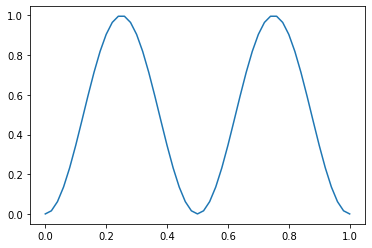

In [225]:
noise_lvl = 0.02

# True m
m_true = dl.Constant(1.)
mx = dl.Constant(0.)

# True solution and derivatives
utrue = dl.Expression('sin(2*pi*x[0]) * sin(2*pi*x[0])', degree=3)
ux = dl.Expression('4 * pi * sin(2*pi*x[0]) * cos(2*pi*x[0])', degree=3)
uxx = dl.Expression('-8*pi*pi*( sin(2*pi*x[0]) * sin(2*pi*x[0]) - cos(2*pi*x[0]) * cos(2*pi*x[0]) )', degree=3)

f = -mx*ux - m*uxx

FEM_model = FEM_function(Vh, vec_mesh = mesh_vec, bc = bc)
data = dl.Function(Vh, FEM_model.forward_data(m_true, f, noise_lvl))

dl.plot(data)
plt.show()


# Loss and optimizer

In [ ]:
# trust region optimizer with SR1 update
res = so.minimize(fun=objSP, jac=gradSP, x0=model.parameters(), method='BFGS', 
                  options={'gtol': 1e-6, 'disp': True})

# Train model